# Tutorial 2: Activation Functions

Again some important import statements

In [1]:
## Standard libraries
import os
import json
import math
import numpy as np 

## Matplotlib imports
import matplotlib.pyplot as plt
%matplotlib inline # For jupyter notebook support
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial2"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


## Common activation functions

Let's first code some activation functions in PyTorch

In [4]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))
    
    
class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

Swish is smooth and non-monotonic (i.e. changes sign of gradient, both increasing and decreasing)
This helps to prevent "dead" neurons, especially for deep networks, while also potentially acting as regularization factor (you will see later what that means). Paper: [1]

In [5]:
##############################

class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0)

##############################

class LeakyReLU(ActivationFunction):
    
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha
        
    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

##############################
    
class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1)

##############################
    
class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
##############################

In [6]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

We can also write an function to get their gradients

In [7]:
def get_grads(act_fn, x):
    x = x.clone().requires_grad_()
    out = act_fn(x)
    out.sum().backward()
    return x.grad

Let's now visualize them

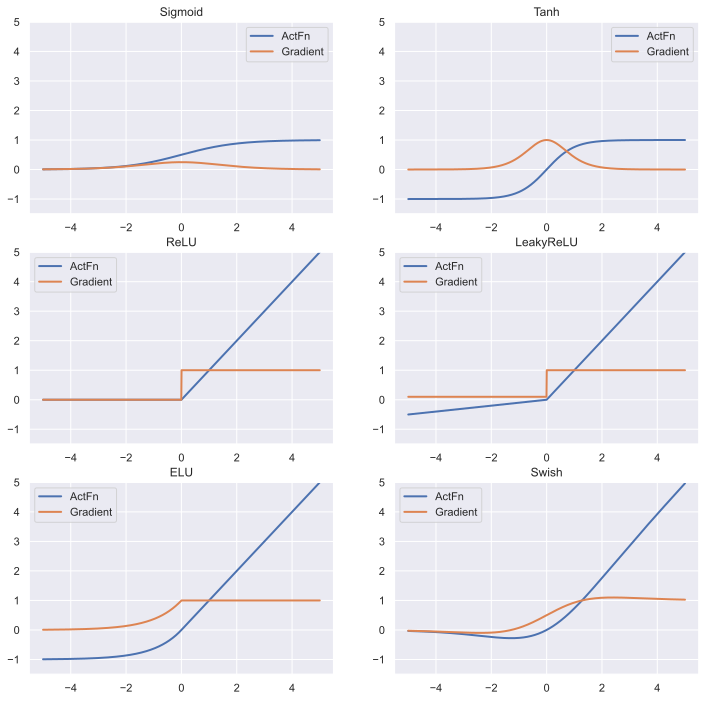

In [8]:
def vis_act_fn(act_fn, ax, x):
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

act_fns = [Sigmoid(), Tanh(), ReLU(), LeakyReLU(), ELU(), Swish()]
x = torch.linspace(-5, 5, 1000)
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(12, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[i//2][i%2], x)
plt.show()

## Anaylsing the effect of activation functions

### Setup

Let's setup a simple network

In [9]:
class BaseNetwork(nn.Module):
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[256, 256, 128, 128]):
        super().__init__()
        
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers)
        
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} # We use this for loading and saving
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.layers(x)
        return out    

In [10]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), "Could not find the config file \"%s\". Are you sure this is the correct path and you have your model config stored here?" % (config_file)
    assert os.path.isfile(model_file), "Could not find the model file \"%s\". Are you sure this is the correct path and you have your model stored here?" % (model_file)
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net
    
def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

We also setup the dataset we want to train it on, namely MNIST:

In [11]:
from torchvision.datasets import MNIST
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=True, pin_memory=True)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

### Gradients

In [23]:
def visualize_gradients(net, color="C0"):
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    
    layer_index = 0
    imgs, labels = imgs.to(device), labels.to(device)
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    grads = {name: params.grad.view(-1).cpu().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()
    
    
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*4, 4))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.distplot(grads[key], ax=key_ax, color=color)
        key_ax.set_title("%s" % key)
        fig_index += 1
    fig.suptitle("Gradient distribution for activation function %s" % (net.config["act_fn"]["name"]), fontsize=14, y=1.05)
    plt.show()
    plt.close() 

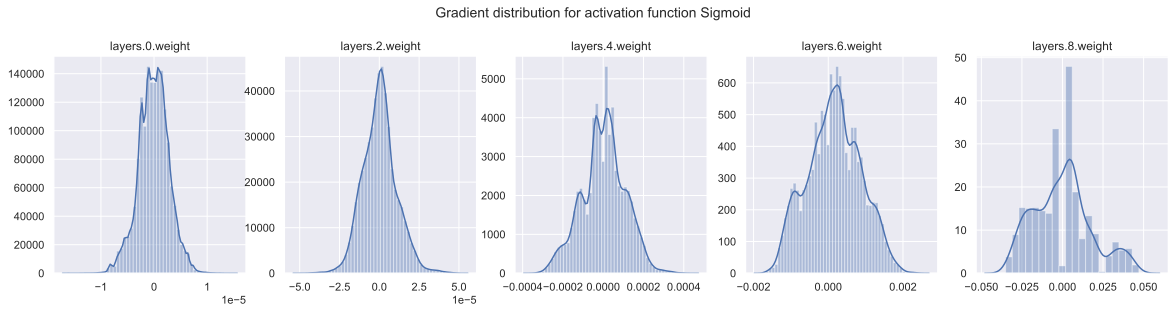

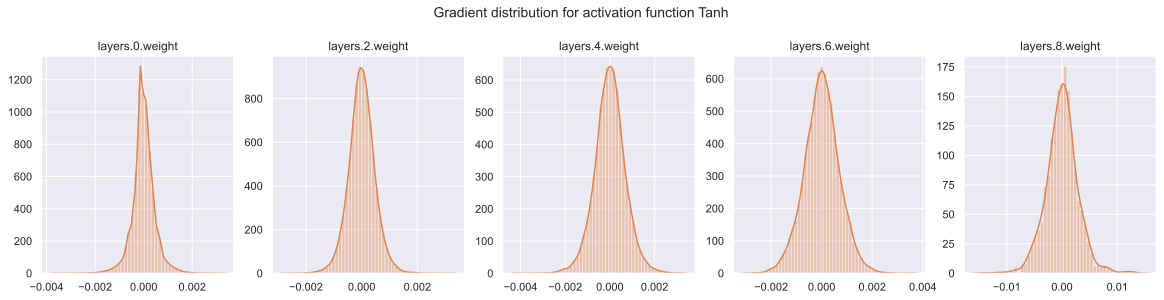

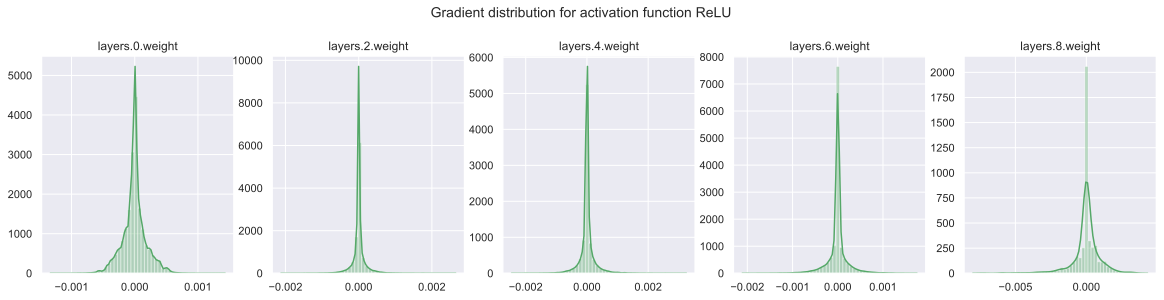

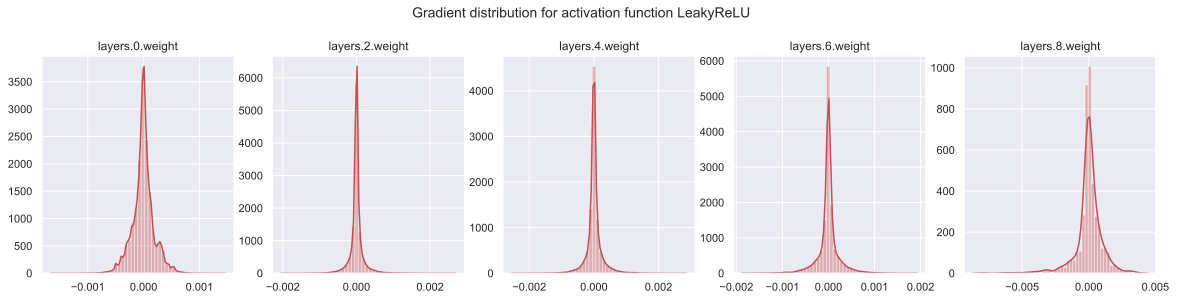

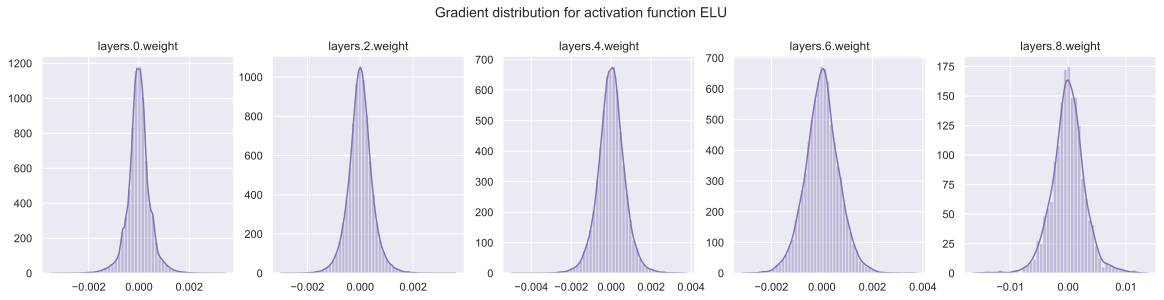

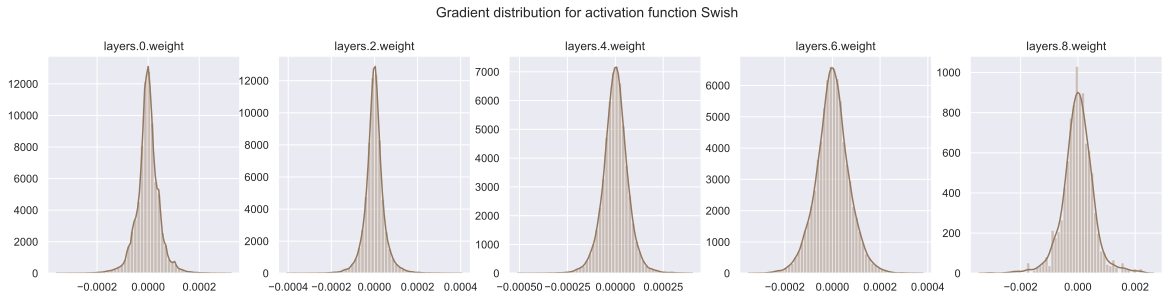

In [24]:
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color="C%i"%i)

### Training a model

In [14]:
def train_model(net, model_name, max_epochs=50, patience=5, batch_size=256, overwrite=False):
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
            
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ##############
            ## Training ##
            #############
            net.train()
            # for imgs, labels in tqdm(train_loader, desc="Epoch %i" % (epoch+1)):
            for imgs, labels in train_loader_local:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()


            ################
            ## Validation ##
            ################
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print("[Epoch %i] Validation accuracy: %4.2f%%" % (epoch+1, val_acc*100.0))

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("New best validation performance, saving model...")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print("Early stopping due to no improvement over the last %i epochs" % (patience))
                break

        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title("Validation performance of %s" % model_name)
        plt.show()
        plt.close()
    
    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((" Test accuracy: %4.2f%% " % (test_acc*100.0)).center(50, "="))
    return test_acc
    

def test_model(net, data_loader):
    net.eval()
    TP, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            TP += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = TP / count
    return test_acc 

In [15]:
for act_fn_name in act_fn_by_name:
    print("Training BaseNetwork with %s activation..." % act_fn_name)
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, "MNIST_%s" % act_fn_name, overwrite=False)

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============= Test accuracy: 11.35% ==============
Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
============= Test accuracy: 97.93% ==============
Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
============= Test accuracy: 97.57% ==============
Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 97.73% ==============
Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
============= Test accuracy: 97.46% ==============
Training BaseNetwork with swish activation...
Model file already exists. Skipping training...
============= Test accuracy: 97.41% ==============


### Activation distribution 

Next we will visualize the distributions after the activation function inside the network

In [21]:
def visualize_activations(net, color="C0"):
    activations = {}
    
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()
    
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*4, rows*4))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.distplot(activations[key], ax=key_ax, color=color)
        key_ax.set_title("Layer %i - %s" % (key, net.layers[key].__class__.__name__))
        fig_index += 1
    fig.suptitle("Activation distribution for activation function %s" % (net.config["act_fn"]["name"]), fontsize=14)
    plt.show()
    plt.close() 

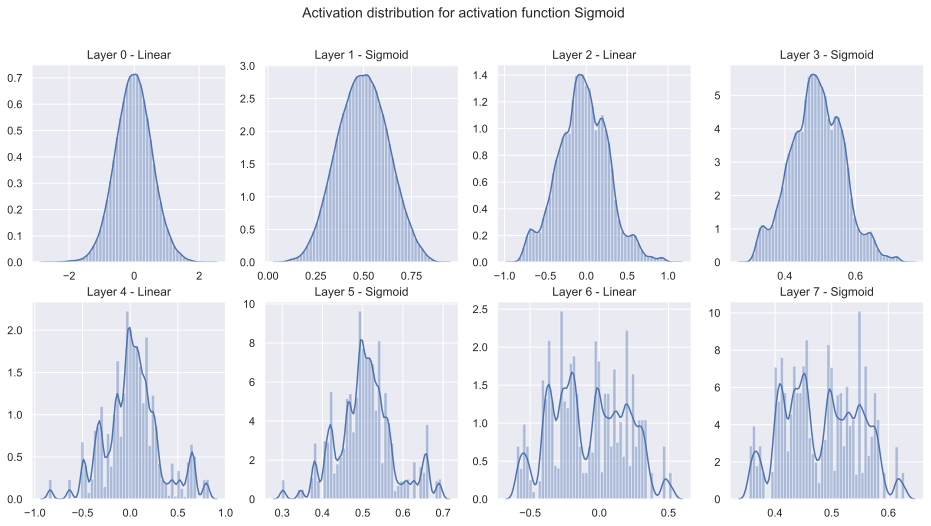

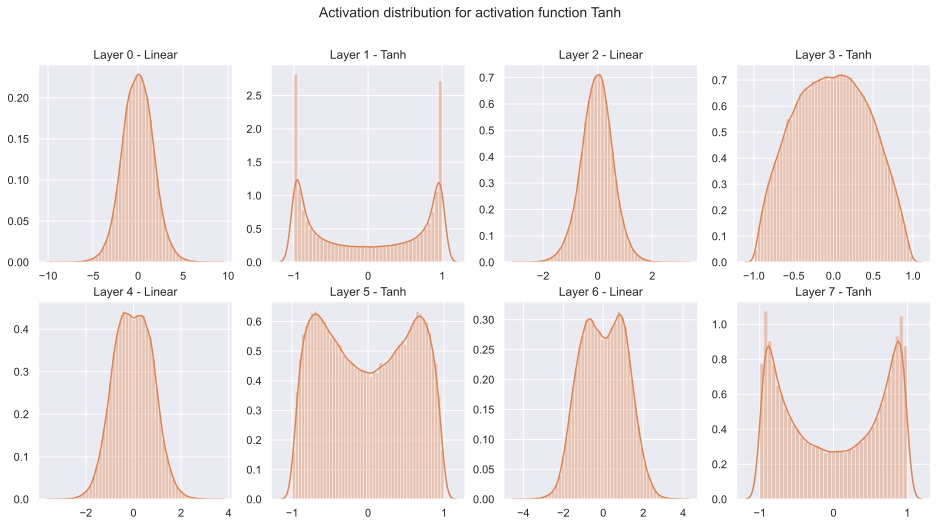

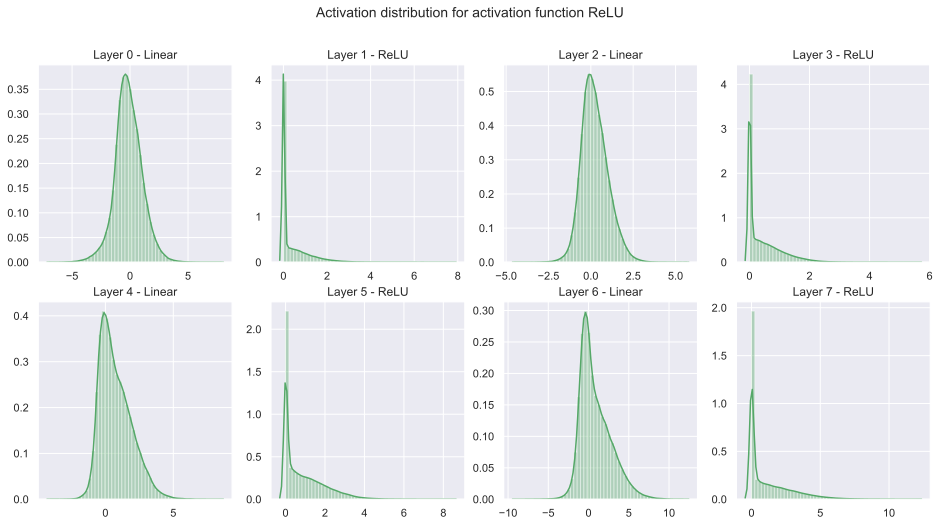

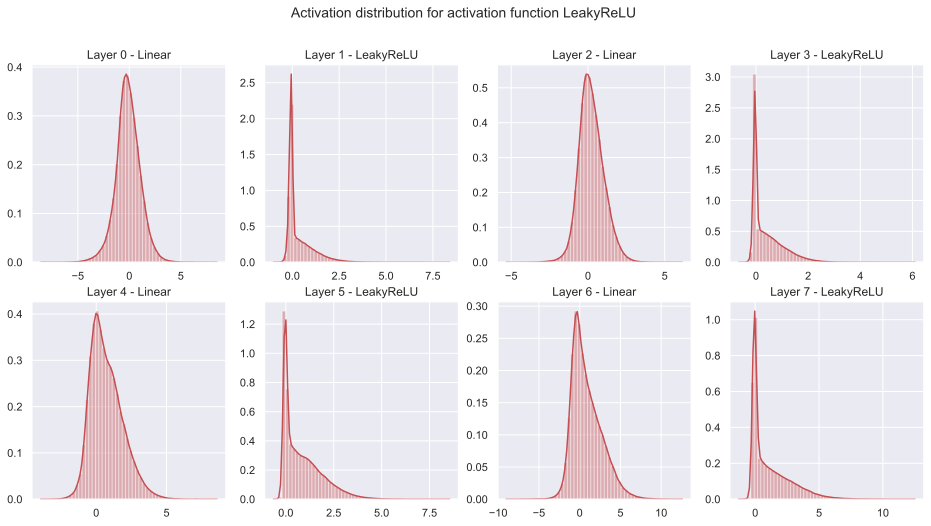

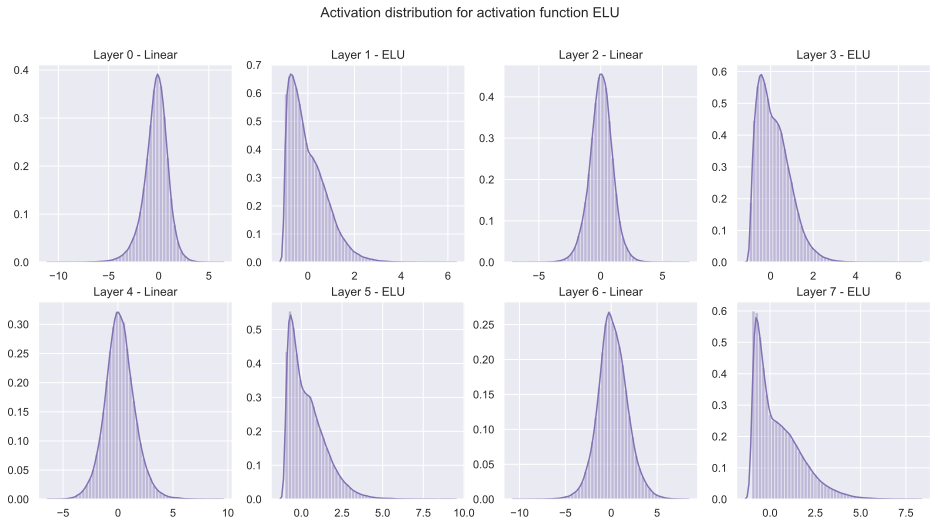

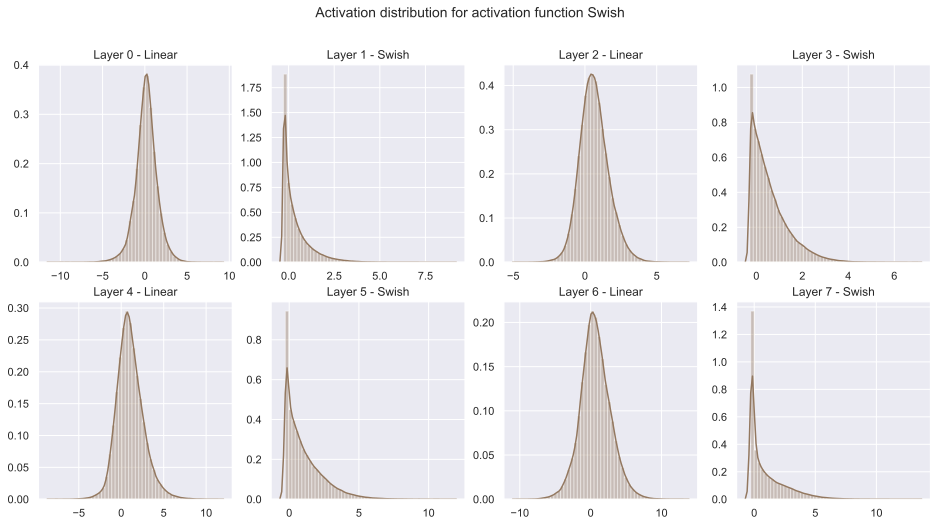

In [22]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name="MNIST_%s" % act_fn_name).to(device)
    visualize_activations(net_actfn, color="C%i" % i)

### Dead Neurons in ReLU networks

We can measure how many dead neurons the network has by running the network on the whole training set and recording whether a neuron is 0 all the time or not:

In [18]:
def measure_number_dead_neurons(net):

    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ] # Same shapes as hidden size in BaseNetwork

    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_loader):
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, ActivationFunction):
                    neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                    layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)

First, we can measure the number of dead neurons for an untrained network:

In [25]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 256, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

100%|██████████| 48/48 [00:04<00:00,  9.73it/s]

Number of dead neurons: [2, 4, 5, 35, 87, 91, 69, 70, 62]


How does this look like for a trained network?

In [20]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="MNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

100%|██████████| 48/48 [00:04<00:00,  9.97it/s]

Number of dead neurons: [2, 0, 1, 5]


We can see that the number of dead neurons stayed constant for the first layer, as the input never changed, but the next layers did change because the input to them, i.e. the activations of the previous layer, changed and thereby turned some dead neurons "alive" again

However, the issue of dead neurons especially arises in very deep networks. Take for example the following network:

In [26]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

100%|██████████| 48/48 [00:04<00:00,  9.68it/s]


Number of dead neurons: [2, 4, 5, 35, 88, 60, 58, 61, 72, 56]


The number of dead neurons is increasing which harms the gradient flow especially in the first iterations. Hence, it is advisible to use other nonlinearities like Swish for very deep networks.

# Exercises

1. Try to manually find the gradients for all activation functions
2. Implement other activation functions that you find in PyTorch's documentation, like GELU and PReLU

# References

[1] Ramachandran, Prajit, Barret Zoph, and Quoc V. Le. "Searching for activation functions." arXiv preprint arXiv:1710.05941 (2017). [Paper link](https://arxiv.org/abs/1710.05941) 